# Semantic Image segmentation

This tutorial focuses on the task of semantic image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case you will want to assign a class to each pixel of the image. This task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [1]:
%pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-zkhqjtfi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-zkhqjtfi
  Resolved https://github.com/tensorflow/examples.git to commit 110c2fd12b5310afaa276fec72605849e27c068e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-110c2fd12b5310afaa276fec72605849e27c068e_-py3-none-any.whl size=268466 sha256=93623968c66ccbb96099915c68bb1bc45051d37f450f7eee3eacc9a3072a31d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-8i_93jt_/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Di

In [2]:
%pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 KB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 261.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 287.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 296.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 277.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 262.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 274.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 186.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 329.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 179.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 292.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
%pip install tensorflow --upgrade

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_addons as tfa


/opt/app-root/lib64/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
from scipy import io

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [6]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [7]:
!echo $PWD

/opt/app-root/src/Semantic-Image-Segmentation


In [8]:
!ls clothing-co-parsing/

annotations  label_list.mat  photos	show_image_anno.m
example.jpg  LICENSE	     README.md	show_pixel_anno.m


In [9]:
images = []
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

2022-02-15 00:42:35.342624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/app-root/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-02-15 00:42:35.342670: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-15 00:42:35.342709: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub-nb-amirgholipour): /proc/driver/nvidia/version does not exist
2022-02-15 00:42:35.343188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow wi

In [10]:
masks = []
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [11]:
len(images), len(masks)

(1000, 1000)

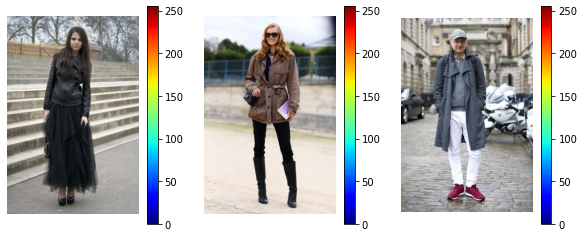

In [12]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [13]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

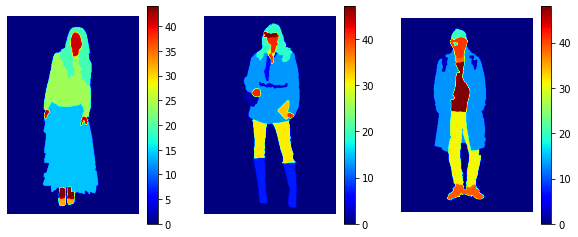

In [14]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

### Data Preprocessing

In [15]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [16]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [17]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

In [18]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='jet') ## tensorflow 2.8
    plt.axis('off')
  plt.show()

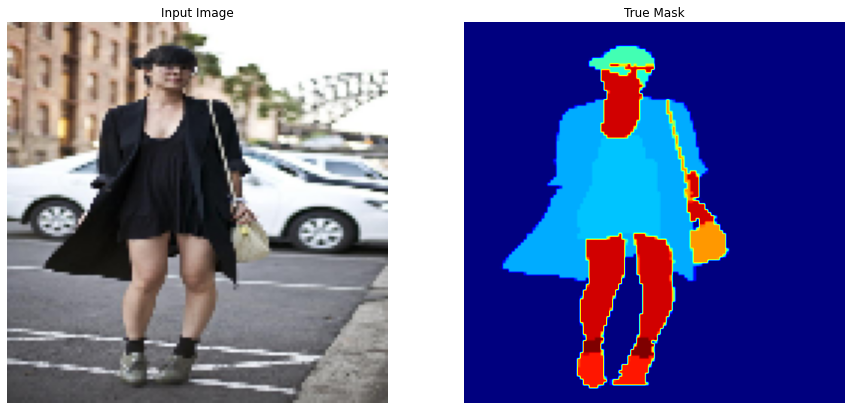

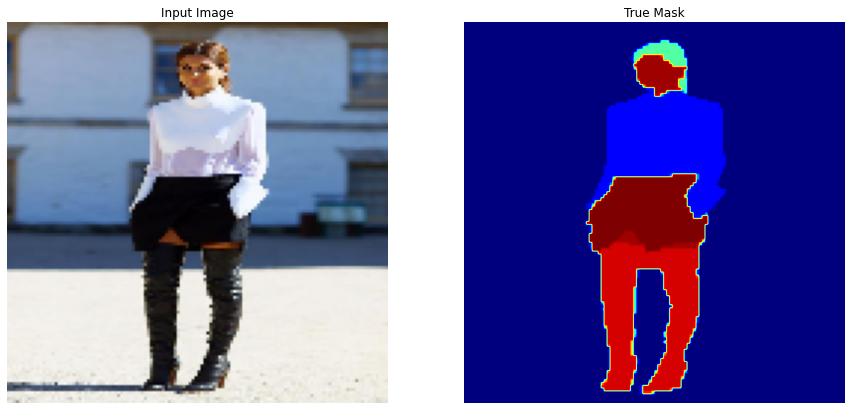

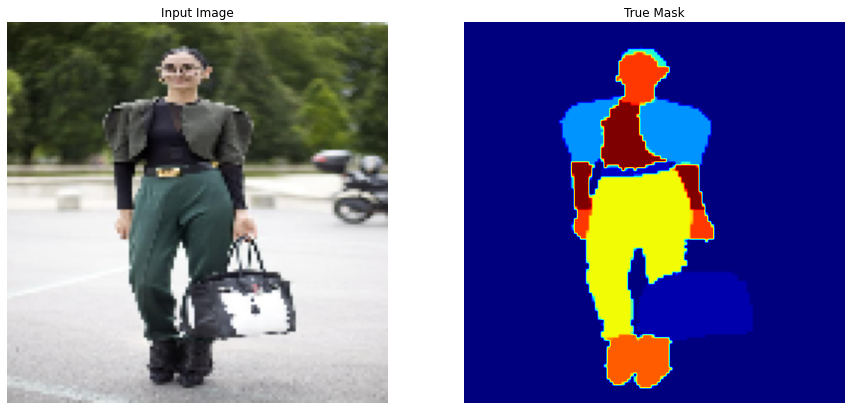

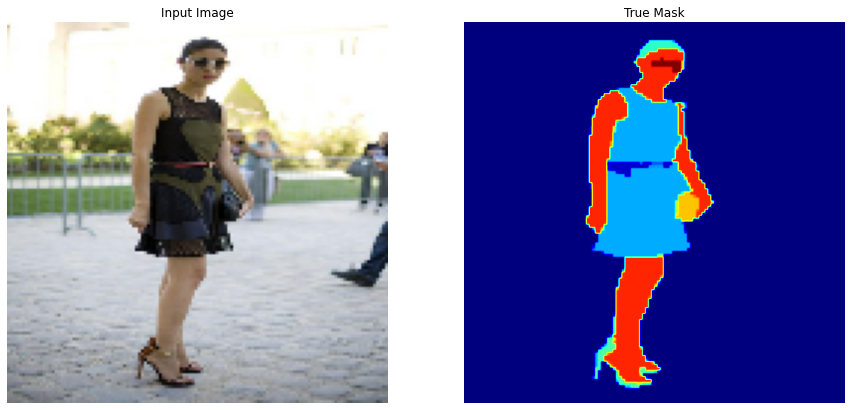

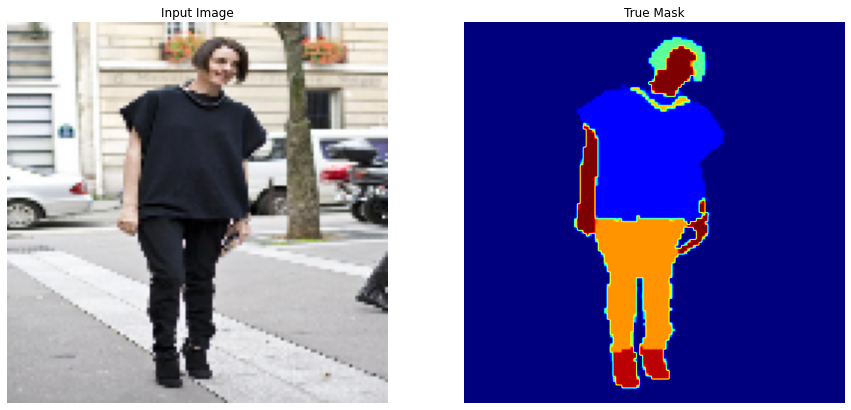

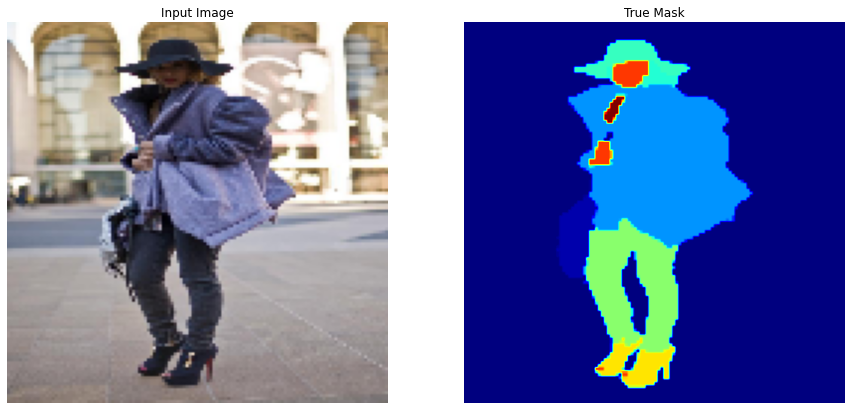

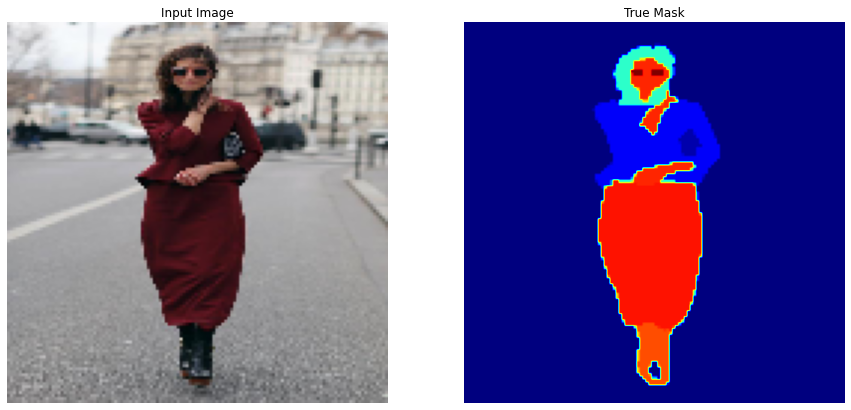

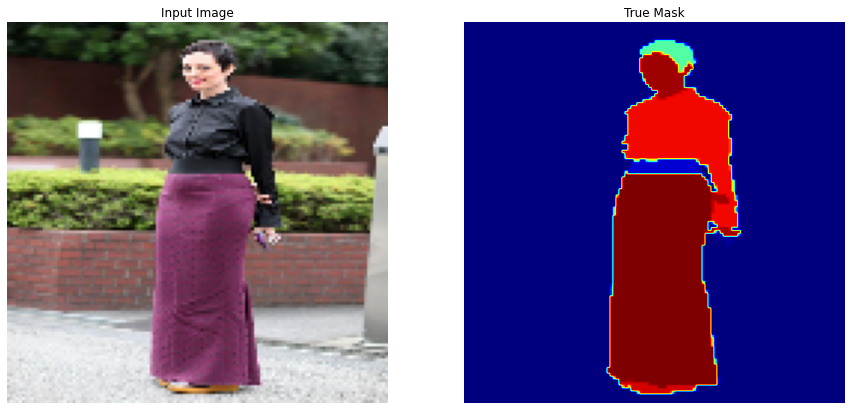

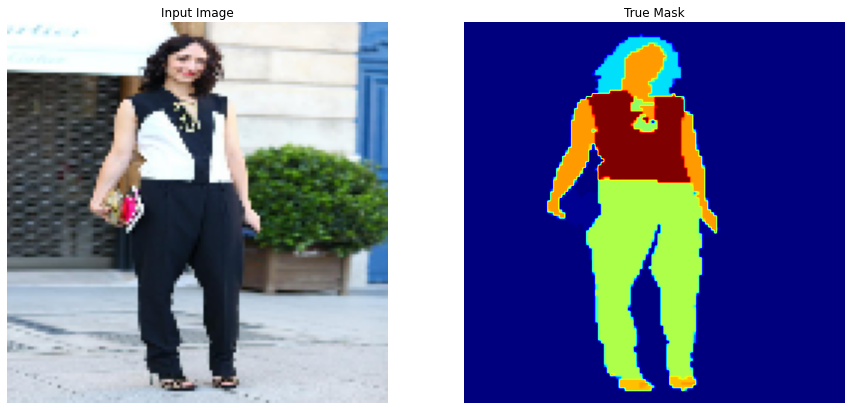

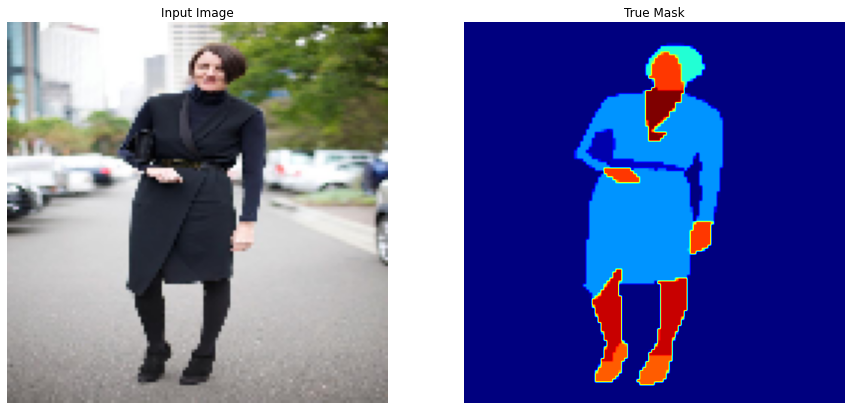

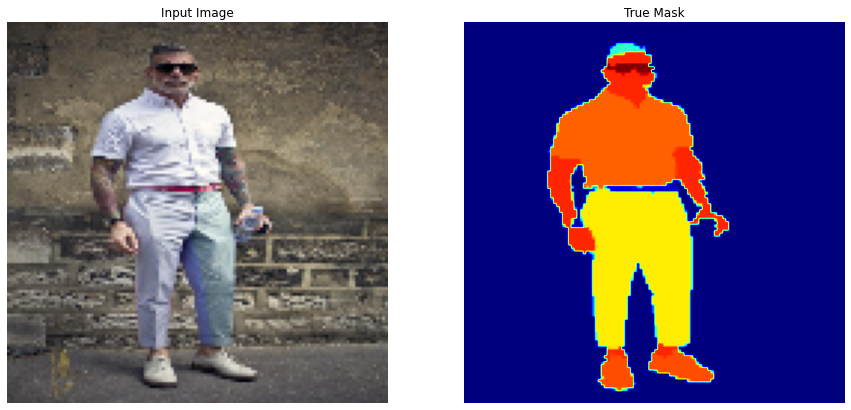

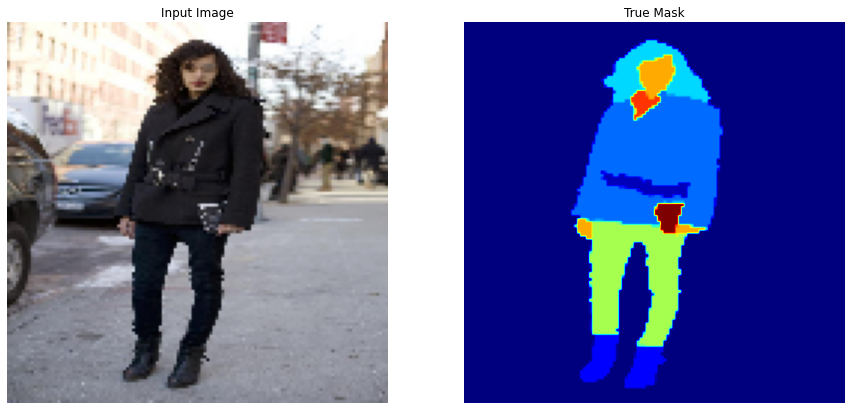

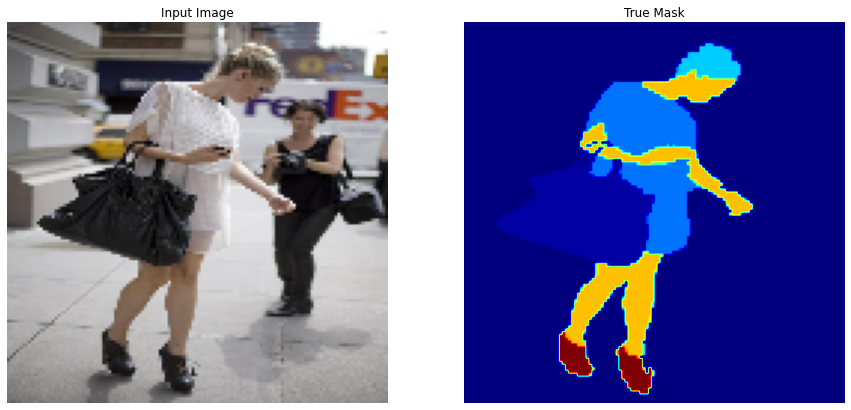

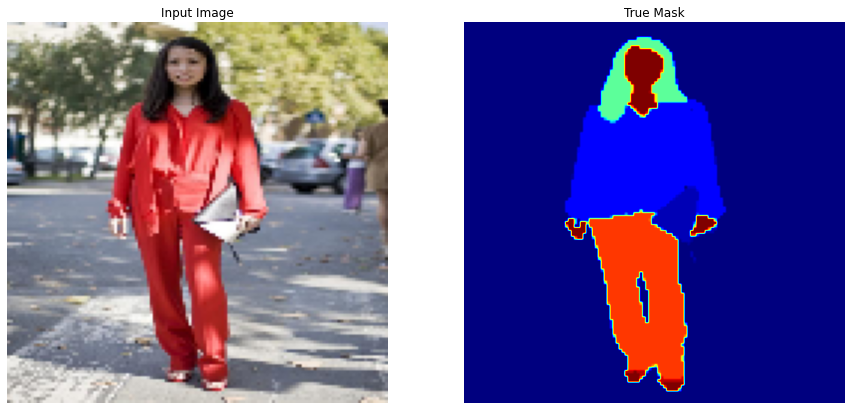

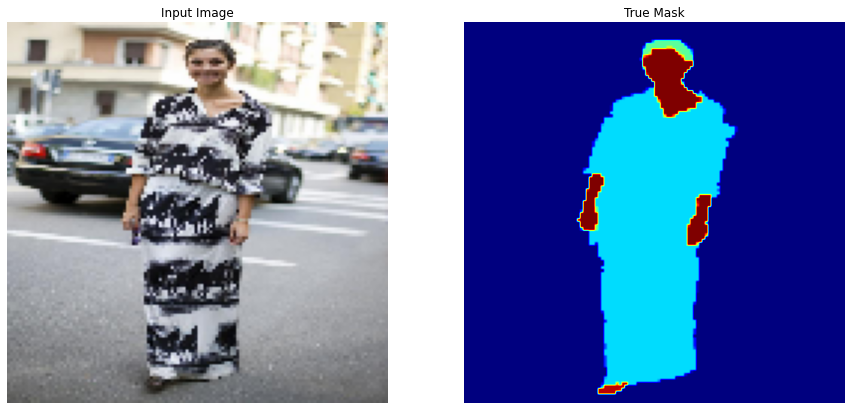

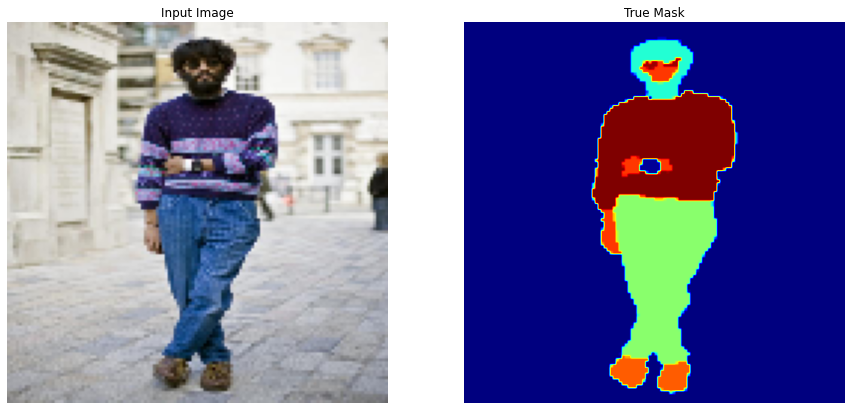

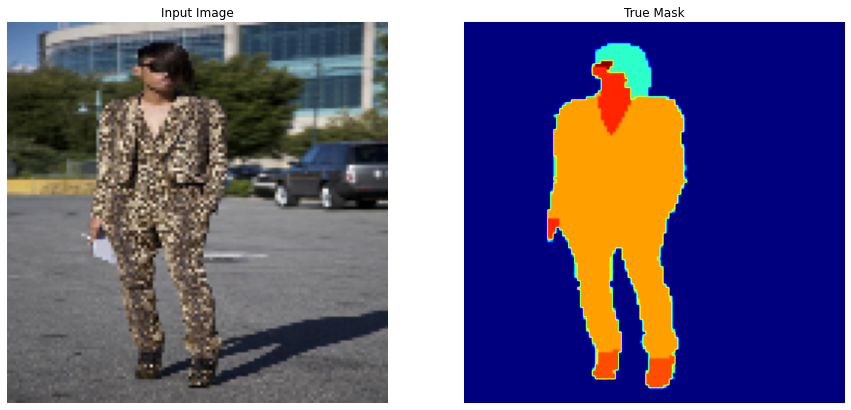

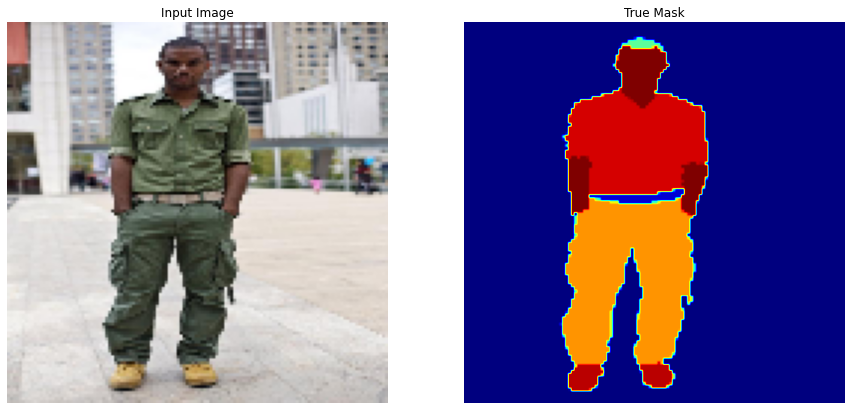

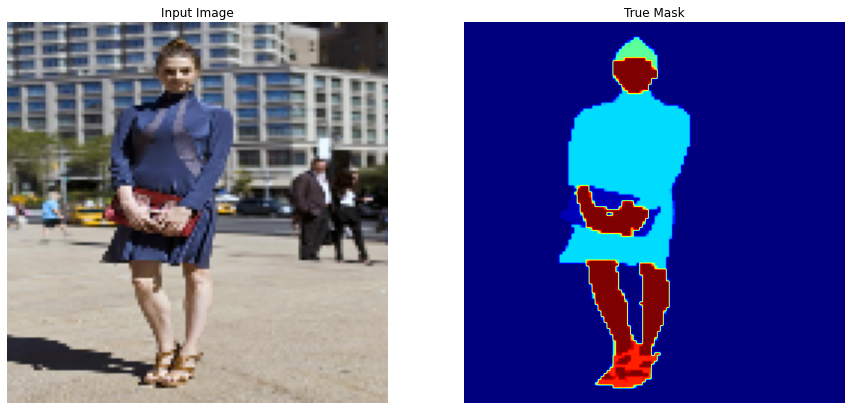

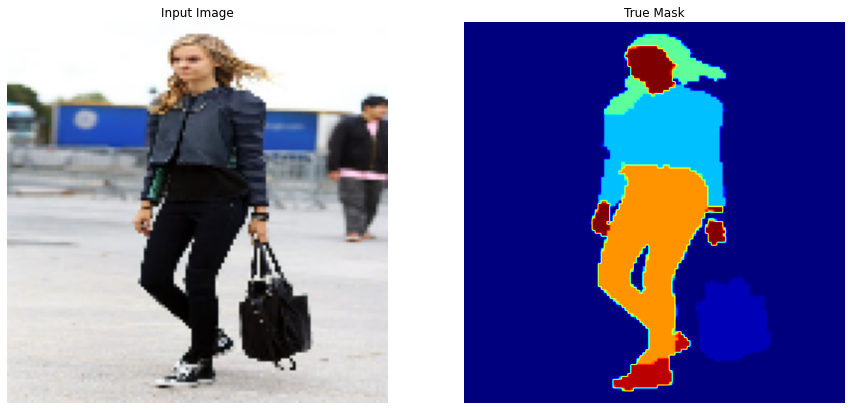

In [19]:
for i in range(10,13):
  sample_image, sample_mask = X[i], y[i]

  # tf.keras.utils.save_img(
  #       'test_sample_'+str(i)+'.jpg', sample_image
  #   )
  # tf.keras.utils.save_img(
  #       'test_sample__mask_'+str(i)+'.jpg', sample_mask
  #   )  

  display([sample_image, sample_mask])

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], pred_mask])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

The callback defined below is used to observe how the model improves while it is training.

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [23]:
type(sample_image)
i=1
tf.keras.utils.save_img(
    'sample_'+str(i)+'.jpg', sample_image
)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

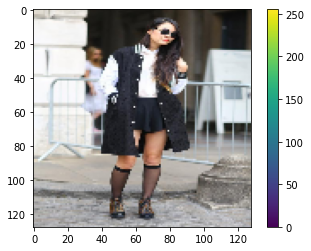

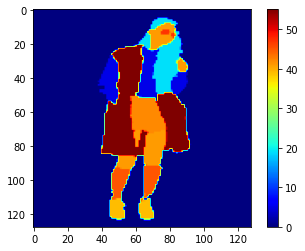

In [24]:
plt.imshow(tf.keras.utils.array_to_img(X[0]))
plt.colorbar()
plt.show()

plt.imshow(y[0], cmap='jet')
plt.colorbar()
plt.show()

### Split Data for training and validation

In [25]:
from sklearn.model_selection import train_test_split

train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

### Data Augmentation

#### Functions for augmentation

In [26]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

Augmentation

In [27]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [28]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

In [29]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - EfficientNetV2B0 - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


In [30]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(input_shape=[128, 128, 3], include_top=False)
print(len(base_model.layers))
# Use the activations of these layers
layer_names = [
    
    #######EfficientNetV2B0
    'block1a_project_activation',   # 64x64
    'block2b_expand_activation',    # 32x32
    'block4a_expand_activation',    # 16x16
    'block6a_expand_activation',    # 8x8
    'block6h_project_conv',         # 4x4
    
#     #######EfficientNetV2B3
# "block1b_project_activation",      # 64x64
# "block2c_expand_activation",       # 32x32
# "block4a_expand_activation",       # 16x16
# "block6a_expand_activation",       # 8x8
# "block6l_project_conv",            # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

255


In [31]:
# base_model.summary()

In [32]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [33]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [34]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x =  tf.keras.layers.Concatenate()([x, skip])

  # This is the last layer of the model
  x = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')(x)  #64x64 -> 128x128

  

  return tf.keras.Model(inputs=inputs, outputs=x)

In [35]:
OUTPUT_CLASSES = 59
model = unet_model(OUTPUT_CLASSES)

### Check for Model and Data compatibility

In [36]:
a,b = next(iter(train))
a.shape



2022-02-15 00:42:57.369802: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([64, 128, 128, 3])

In [37]:
# y = np.concatenate([y for x, y in train], axis=0)


2022-02-15 00:42:58.276670: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


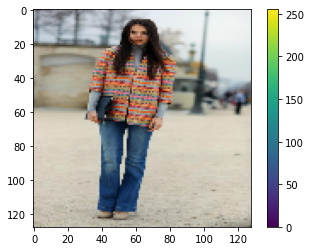

In [38]:
example = next(iter(train))
preds = model(example[0])
plt.imshow(tf.keras.utils.array_to_img(example[0][60]))

plt.colorbar()
plt.show()

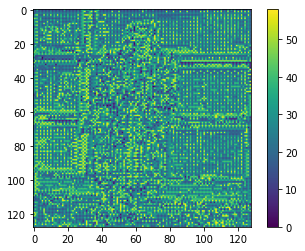

In [39]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

## Compile the model

In [47]:
OUTPUT_CLASSES = 59
model = unet_model(OUTPUT_CLASSES)
### if you have a saved model loaded and continue training
model = tf.keras.models.load_model('./models/SemImSeg_model_EfficientNetV2B0.h5')
model.compile(
    optimizer=tfa.optimizers.Yogi(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Start Model Training

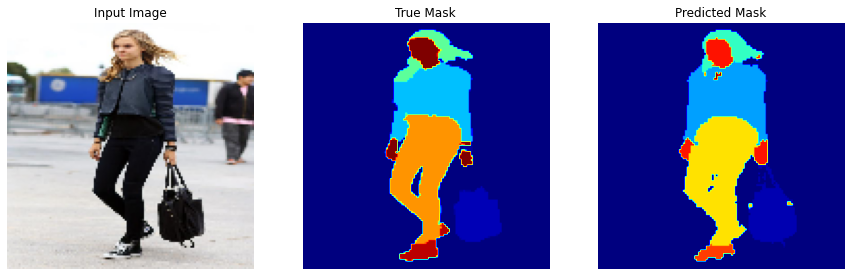


Sample Prediction after epoch 21

12/12 [==============================] - 14s 1s/step - loss: 0.5845 - accuracy: 0.8559 - val_loss: 0.6407 - val_accuracy: 0.8446


In [48]:

EPOCHS = 70
VAL_SUBSPLITS = 5

# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
## Saving the best model
checkpoint_filepath = './models/SemImSeg_model_EfficientNetV2B0.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    #save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
## Early Stoping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, 
)
## Train the model and save the historical information
model_history = model.fit(
    train,
    epochs=EPOCHS,
      steps_per_epoch=STEPS_PER_EPOCH,
      validation_steps=VALIDATION_STEPS,
      validation_data=val,
      callbacks=[DisplayCallback(),model_checkpoint_callback,early_stopping_callback])

#### Performance Curves

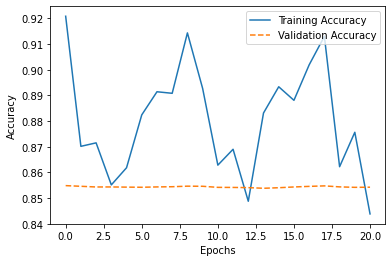

In [42]:
history = model_history.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Thank you for your time!

In [43]:
# model.save('./models/SemImSeg_model_EfficientNetV2B0.h5')

In [44]:
model = tf.keras.models.load_model('./models/SemImSeg_model_EfficientNetV2B0.h5')

## Make predictions

####


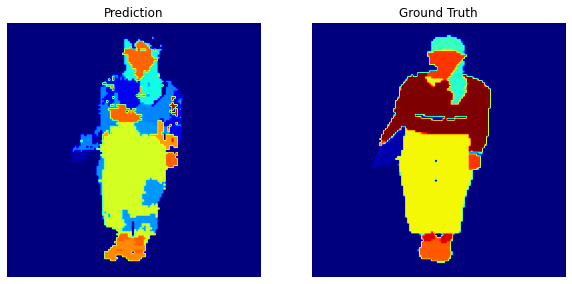

In [45]:
img, mask = next(iter(val))
pred = model.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
  
    print('####')
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break
plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

In [46]:
import os
os.path.getsize('./models/SemImSeg_model_EfficientNetV2B0.h5')

75013888